Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved. This source code is licensed under the license found in the LICENSE file in the root directory of this source tree.

# Video Seal - Image inference

In [1]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
%cd /home/teaching/Desktop/Grp_22/BiometricSEAL/videoseal/

/home/teaching/Desktop/Grp_22/BiometricSEAL/videoseal


In [2]:
import os
import omegaconf
from tqdm import tqdm
import gc
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torchvision

from videoseal.utils.display import save_img
from videoseal.utils import Timer
from videoseal.evals.full import setup_model_from_checkpoint
from videoseal.evals.metrics import bit_accuracy, psnr, ssim
from videoseal.augmentation import Identity, JPEG, Crop
from videoseal.modules.jnd import JND

to_tensor = torchvision.transforms.ToTensor()
to_pil = torchvision.transforms.ToPILImage()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" 

def plot_images(original, watermarked, diff):
    # plot original image, watermarked image, and difference
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(watermarked.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Watermarked Image")
    axes[1].axis("off")

    axes[2].imshow(diff.permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Difference Image")
    axes[2].axis("off")

    plt.show()


/home/teaching/anaconda3/envs/videoseal/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/teaching/anaconda3/envs/videoseal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


Model loaded successfully from outputSTOPPING/checkpoint138.pth with message: <All keys matched successfully>


Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.698256].


Msg :  tensor([0.5269, 0.7299, 0.4344, 0.9621, 0.2766, 0.7341, 0.9954, 0.2659, 0.2238,
        0.1520, 0.0695, 0.2630, 0.1985, 0.2162, 0.3231, 0.9068, 0.5174, 0.5859,
        0.7610, 0.1499, 0.2124, 0.1617, 0.4060, 0.3232, 0.3127, 0.4441, 0.8911,
        0.4315, 0.6332, 0.8104, 0.7818, 0.1106, 0.1232, 0.9885, 0.0655, 0.6409,
        0.6323, 0.8991, 0.9548, 0.2402, 0.4235, 0.8128, 0.9042, 0.5978, 0.6433,
        0.1622, 0.0847, 0.5150, 0.1097, 0.7391, 0.4146, 0.1145, 0.0381, 0.3622,
        0.8429, 0.5824, 0.8831, 0.9594, 0.8313, 0.9718, 0.1513, 0.3631, 0.9916,
        0.9046, 0.5849, 0.3820, 0.9362, 0.2549, 0.6896, 0.4823, 0.9674, 0.2904,
        0.2140, 0.8406, 0.7265, 0.9220, 0.1947, 0.3069, 0.5730, 0.6424, 0.6527,
        0.1297, 0.7587, 0.2753, 0.1172, 0.7148, 0.2206, 0.4267, 0.8850, 0.3181,
        0.8597, 0.5841, 0.4115, 0.9093, 0.7505, 0.4140, 0.8643, 0.6134, 0.6032,
        0.1683, 0.2246, 0.1358, 0.0515, 0.1039, 0.8154, 0.2128, 0.5947, 0.3097,
        0.9972, 0.1165, 0.8626, 0

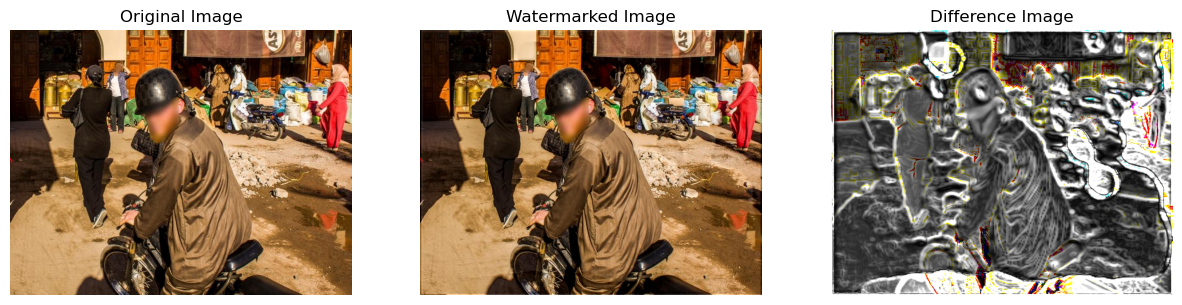

Processing Images:  20%|██        | 1/5 [00:00<00:02,  1.39it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.2814937].


Msg :  tensor([0.5269, 0.7299, 0.4344, 0.9621, 0.2766, 0.7341, 0.9954, 0.2659, 0.2238,
        0.1520, 0.0695, 0.2630, 0.1985, 0.2162, 0.3231, 0.9068, 0.5174, 0.5859,
        0.7610, 0.1499, 0.2124, 0.1617, 0.4060, 0.3232, 0.3127, 0.4441, 0.8911,
        0.4315, 0.6332, 0.8104, 0.7818, 0.1106, 0.1232, 0.9885, 0.0655, 0.6409,
        0.6323, 0.8991, 0.9548, 0.2402, 0.4235, 0.8128, 0.9042, 0.5978, 0.6433,
        0.1622, 0.0847, 0.5150, 0.1097, 0.7391, 0.4146, 0.1145, 0.0381, 0.3622,
        0.8429, 0.5824, 0.8831, 0.9594, 0.8313, 0.9718, 0.1513, 0.3631, 0.9916,
        0.9046, 0.5849, 0.3820, 0.9362, 0.2549, 0.6896, 0.4823, 0.9674, 0.2904,
        0.2140, 0.8406, 0.7265, 0.9220, 0.1947, 0.3069, 0.5730, 0.6424, 0.6527,
        0.1297, 0.7587, 0.2753, 0.1172, 0.7148, 0.2206, 0.4267, 0.8850, 0.3181,
        0.8597, 0.5841, 0.4115, 0.9093, 0.7505, 0.4140, 0.8643, 0.6134, 0.6032,
        0.1683, 0.2246, 0.1358, 0.0515, 0.1039, 0.8154, 0.2128, 0.5947, 0.3097,
        0.9972, 0.1165, 0.8626, 0

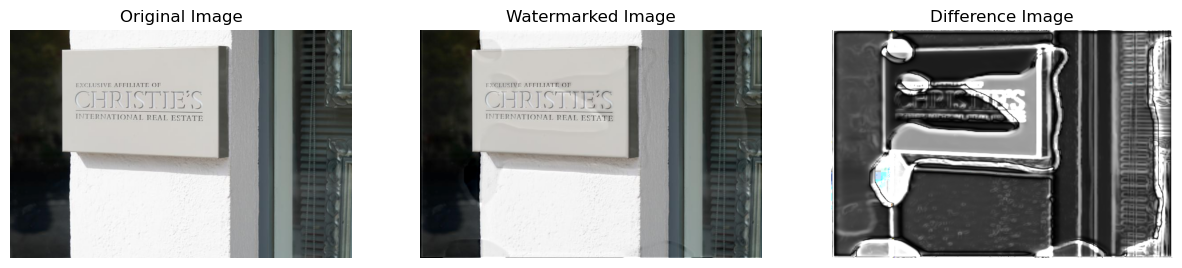

Processing Images:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.545741].


Msg :  tensor([0.5269, 0.7299, 0.4344, 0.9621, 0.2766, 0.7341, 0.9954, 0.2659, 0.2238,
        0.1520, 0.0695, 0.2630, 0.1985, 0.2162, 0.3231, 0.9068, 0.5174, 0.5859,
        0.7610, 0.1499, 0.2124, 0.1617, 0.4060, 0.3232, 0.3127, 0.4441, 0.8911,
        0.4315, 0.6332, 0.8104, 0.7818, 0.1106, 0.1232, 0.9885, 0.0655, 0.6409,
        0.6323, 0.8991, 0.9548, 0.2402, 0.4235, 0.8128, 0.9042, 0.5978, 0.6433,
        0.1622, 0.0847, 0.5150, 0.1097, 0.7391, 0.4146, 0.1145, 0.0381, 0.3622,
        0.8429, 0.5824, 0.8831, 0.9594, 0.8313, 0.9718, 0.1513, 0.3631, 0.9916,
        0.9046, 0.5849, 0.3820, 0.9362, 0.2549, 0.6896, 0.4823, 0.9674, 0.2904,
        0.2140, 0.8406, 0.7265, 0.9220, 0.1947, 0.3069, 0.5730, 0.6424, 0.6527,
        0.1297, 0.7587, 0.2753, 0.1172, 0.7148, 0.2206, 0.4267, 0.8850, 0.3181,
        0.8597, 0.5841, 0.4115, 0.9093, 0.7505, 0.4140, 0.8643, 0.6134, 0.6032,
        0.1683, 0.2246, 0.1358, 0.0515, 0.1039, 0.8154, 0.2128, 0.5947, 0.3097,
        0.9972, 0.1165, 0.8626, 0

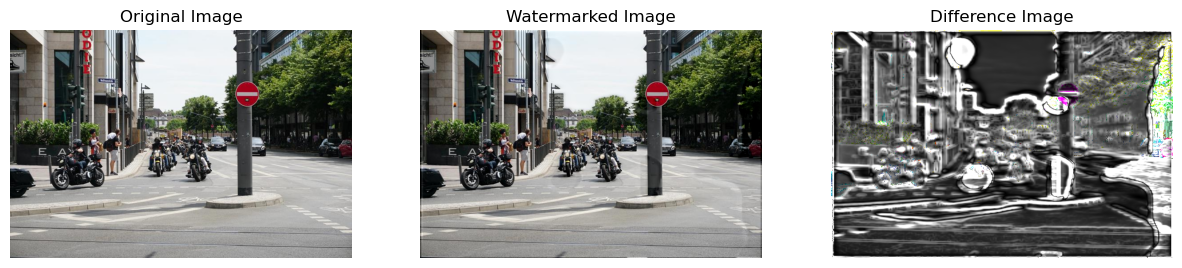

Processing Images:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Msg :  tensor([0.5269, 0.7299, 0.4344, 0.9621, 0.2766, 0.7341, 0.9954, 0.2659, 0.2238,
        0.1520, 0.0695, 0.2630, 0.1985, 0.2162, 0.3231, 0.9068, 0.5174, 0.5859,
        0.7610, 0.1499, 0.2124, 0.1617, 0.4060, 0.3232, 0.3127, 0.4441, 0.8911,
        0.4315, 0.6332, 0.8104, 0.7818, 0.1106, 0.1232, 0.9885, 0.0655, 0.6409,
        0.6323, 0.8991, 0.9548, 0.2402, 0.4235, 0.8128, 0.9042, 0.5978, 0.6433,
        0.1622, 0.0847, 0.5150, 0.1097, 0.7391, 0.4146, 0.1145, 0.0381, 0.3622,
        0.8429, 0.5824, 0.8831, 0.9594, 0.8313, 0.9718, 0.1513, 0.3631, 0.9916,
        0.9046, 0.5849, 0.3820, 0.9362, 0.2549, 0.6896, 0.4823, 0.9674, 0.2904,
        0.2140, 0.8406, 0.7265, 0.9220, 0.1947, 0.3069, 0.5730, 0.6424, 0.6527,
        0.1297, 0.7587, 0.2753, 0.1172, 0.7148, 0.2206, 0.4267, 0.8850, 0.3181,
        0.8597, 0.5841, 0.4115, 0.9093, 0.7505, 0.4140, 0.8643, 0.6134, 0.6032,
        0.1683, 0.2246, 0.1358, 0.0515, 0.1039, 0.8154, 0.2128, 0.5947, 0.3097,
        0.9972, 0.1165, 0.8626, 0

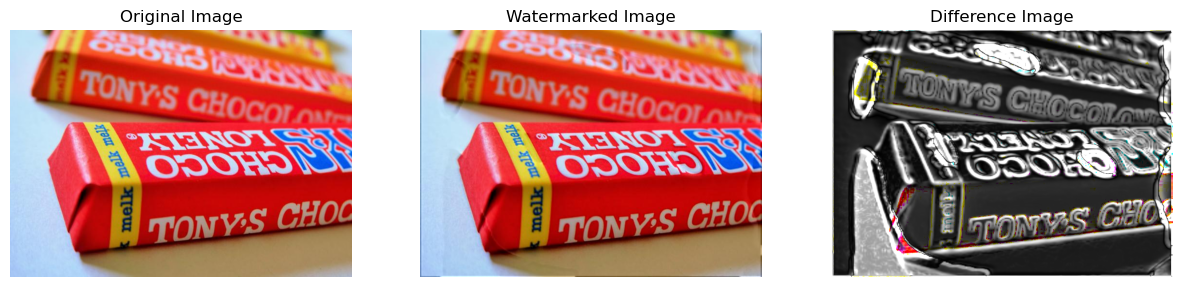

Processing Images:  80%|████████  | 4/5 [00:03<00:00,  1.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.498322].


Msg :  tensor([0.5269, 0.7299, 0.4344, 0.9621, 0.2766, 0.7341, 0.9954, 0.2659, 0.2238,
        0.1520, 0.0695, 0.2630, 0.1985, 0.2162, 0.3231, 0.9068, 0.5174, 0.5859,
        0.7610, 0.1499, 0.2124, 0.1617, 0.4060, 0.3232, 0.3127, 0.4441, 0.8911,
        0.4315, 0.6332, 0.8104, 0.7818, 0.1106, 0.1232, 0.9885, 0.0655, 0.6409,
        0.6323, 0.8991, 0.9548, 0.2402, 0.4235, 0.8128, 0.9042, 0.5978, 0.6433,
        0.1622, 0.0847, 0.5150, 0.1097, 0.7391, 0.4146, 0.1145, 0.0381, 0.3622,
        0.8429, 0.5824, 0.8831, 0.9594, 0.8313, 0.9718, 0.1513, 0.3631, 0.9916,
        0.9046, 0.5849, 0.3820, 0.9362, 0.2549, 0.6896, 0.4823, 0.9674, 0.2904,
        0.2140, 0.8406, 0.7265, 0.9220, 0.1947, 0.3069, 0.5730, 0.6424, 0.6527,
        0.1297, 0.7587, 0.2753, 0.1172, 0.7148, 0.2206, 0.4267, 0.8850, 0.3181,
        0.8597, 0.5841, 0.4115, 0.9093, 0.7505, 0.4140, 0.8643, 0.6134, 0.6032,
        0.1683, 0.2246, 0.1358, 0.0515, 0.1039, 0.8154, 0.2128, 0.5947, 0.3097,
        0.9972, 0.1165, 0.8626, 0

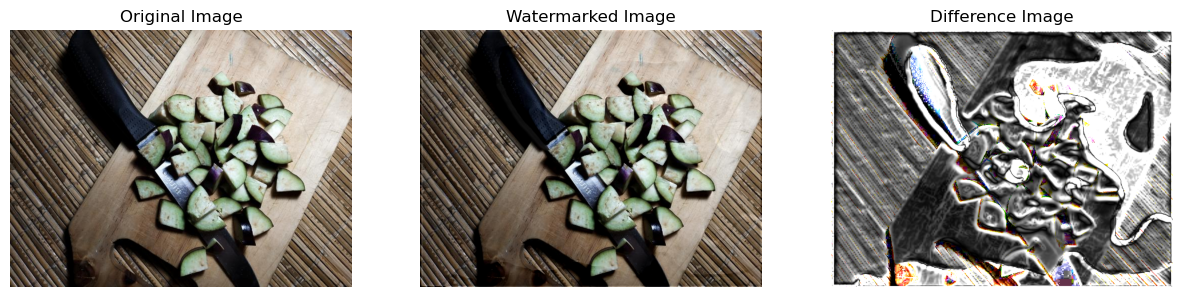

Processing Images: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


In [36]:
# Directory containing images
num_imgs = 5
assets_dir = "./apnaDataset/"
base_output_dir = "outputs"
os.makedirs(base_output_dir, exist_ok=True)

# Checkpoint
ckpts = {
    # "trustmark": "baseline/trustmark",
    # "cin": "baseline/cin",
    # "mbrs": "baseline/mbrs",
    # "videoseal_0.0": 'videoseal_0.0',
    # "videoseal": 'videoseal',
    "custom": "outputSTOPPING/checkpoint138.pth"
}

for ckpt_name, ckpt_path in ckpts.items():

    output_dir = os.path.join(base_output_dir, ckpt_name)
    os.makedirs(output_dir, exist_ok=True)

    # a timer to measure the time
    timer = Timer()

    # Iterate over all ckpts
    model = setup_model_from_checkpoint(ckpt_path)
    model.eval()
    model.compile()
    model.to(device)

    # control the watermark strength with this parameter. The higher the value, the more visible the watermark, but also the more robust it is to attacks.
    model.blender.scaling_w *= 1

    # Iterate over all video files in the directory
    files = [f for f in os.listdir(assets_dir) if f.endswith(".png") or f.endswith(".jpg")]
    files = [os.path.join(assets_dir, f) for f in files]
    files = files[:num_imgs]

    for file in tqdm(files, desc=f"Processing Images"):
        # load image
        imgs = Image.open(file, "r").convert("RGB")  # keep only rgb channels
        imgs = to_tensor(imgs).unsqueeze(0).float()

        # Watermark embedding
        timer.start()
        # idx = random.randint(0, 9)
        custom_msg = torch.load('tensors.pt')[0]
        outputs = model.embed(imgs, msgs=custom_msg, is_video=False, lowres_attenuation=True)
        torch.cuda.synchronize()
        # print(f"embedding watermark  - took {timer.stop():.2f}s")

        # compute diff
        imgs_w = outputs["imgs_w"]  # b c h w
        msgs = outputs["msgs"]  # b k
        diff = imgs_w - imgs
        diff = 25 * diff.abs()

        # save
        timer.start()
        base_save_name = os.path.join(output_dir, os.path.basename(file).replace(".png", ""))
        save_img(imgs[0], f"{base_save_name}_ori.png")
        save_img(imgs_w[0], f"{base_save_name}_wm.png")
        save_img(diff[0], f"{base_save_name}_diff.png")

        # Metrics
        imgs_aug = imgs_w
        outputs = model.detect(imgs, is_video=False)
        metrics = {
            "file": file,
            "bit_accuracy": bit_accuracy(
                outputs["preds"][:, 1:],
                msgs
            ).nanmean().item(),
            "psnr": psnr(imgs_w, imgs).item(),
            "ssim": ssim(imgs_w, imgs).item()
        }
        print("Msg : ", msgs)
        print("Preds : ", outputs["preds"][:, 1:])
        # Augment images
        # for qf in [80, 40]:
        #     imgs_aug, _ = Crop(0.5, 0.7)(imgs_w, None)
        #     # detect
        #     timer.start()
        #     outputs = model.detect(imgs_aug, is_video=True)
        #     preds = outputs["preds"]
        #     bit_preds = preds[:, 1:]  # b k ...
        #     print("Bits preds: ", bit_preds)
        #     bit_accuracy_ = bit_accuracy(
        #         bit_preds,
        #         msgs
        #     ).nanmean().item()
            
        #     metrics[f"bit_accuracy_qf{qf}"] = bit_accuracy_

        print(metrics)
        plot_images(imgs[0], imgs_w[0], diff[0])

        my_output = outputs

        del outputs, imgs, imgs_w, diff

    # Free model from GPU
    del model
    torch.cuda.empty_cache()

In [37]:
preds = torch.tensor([[0.5628, 0.4883, 0.5261, 0.5028, 0.3700, 0.4362, 0.6071, 0.3762, 0.4973,
         0.5670, 0.3292, 0.4905, 0.4752, 0.4962, 0.4117, 0.5581, 0.4881, 0.4792,
         0.6554, 0.4662, 0.3530, 0.6945, 0.5650, 0.6016, 0.2872, 0.4280, 0.2700,
         0.4355, 0.6405, 0.5554, 0.4499, 0.6744, 0.4941, 0.4623, 0.5391, 0.5462,
         0.5097, 0.4992, 0.5382, 0.4477, 0.5345, 0.3563, 0.4671, 0.6734, 0.4564,
         0.6373, 0.5408, 0.3480, 0.4721, 0.6741, 0.3336, 0.5779, 0.5711, 0.4939,
         0.5078, 0.4900, 0.6457, 0.6737, 0.5832, 0.4588, 0.5024, 0.4862, 0.5512,
         0.6981, 0.5132, 0.4648, 0.4489, 0.4595, 0.4513, 0.5469, 0.6161, 0.6966,
         0.5469, 0.5303, 0.6017, 0.4634, 0.4899, 0.4554, 0.4133, 0.4240, 0.5145,
         0.4236, 0.6086, 0.4974, 0.4213, 0.6283, 0.4119, 0.3547, 0.5545, 0.5730,
         0.5213, 0.5406, 0.5531, 0.6678, 0.4225, 0.4036, 0.5184, 0.4715, 0.4368,
         0.4558, 0.4438, 0.4505, 0.4205, 0.5187, 0.4923, 0.5209, 0.4131, 0.4411,
         0.3991, 0.6091, 0.5774, 0.3224, 0.4843, 0.5194, 0.5312, 0.6082, 0.6501,
         0.6490, 0.4492, 0.4895, 0.4877, 0.3151, 0.5383, 0.4178, 0.4838, 0.5245,
         0.2904, 0.3934]])

In [50]:
tensors = torch.load('distinct.pt')

def cos(a, b):
    # Flatten tensors if they have different shapes
    a_flat = a.flatten().unsqueeze(0)
    b_flat = b.flatten().unsqueeze(0)
    return torch.nn.functional.cosine_similarity(a_flat, b_flat, dim=1)[0]

In [51]:
l = [[0 for i in range(len(tensors))] for j in range(len(tensors))]

for i in range(len(tensors)):
    for j in range(len(tensors)):
        l[i][j] = cos(tensors[i], tensors[j])
        

In [53]:
print(tensors[0])

tensor([-0.2022, -0.0077,  0.0482,  0.0322, -0.0112,  0.1200,  0.0636, -0.0453,
        -0.1341,  0.0932, -0.1028,  0.0598, -0.0272,  0.1808,  0.0796, -0.0012,
         0.0179,  0.0708, -0.0723, -0.1084, -0.1330, -0.0489, -0.1186, -0.0068,
         0.1451, -0.0558,  0.0375,  0.1280,  0.0373,  0.1115,  0.0229,  0.0031,
        -0.1002,  0.0638,  0.0568, -0.0332,  0.0040, -0.0031, -0.0511, -0.1016,
         0.0346, -0.0020, -0.0012, -0.0913, -0.0338, -0.2034,  0.0590,  0.1314,
        -0.0773, -0.1763, -0.0544,  0.0255, -0.0844,  0.0274, -0.0592, -0.1054,
         0.0089,  0.0319, -0.0152,  0.1377,  0.0649, -0.1155, -0.0798, -0.0871,
        -0.2320, -0.0489,  0.0599, -0.0271, -0.0688,  0.0401, -0.0153, -0.0186,
        -0.1005,  0.0777,  0.0698,  0.0119,  0.0142, -0.0277, -0.1048,  0.0004,
         0.1398,  0.0855,  0.1126, -0.0146,  0.0826, -0.0402, -0.0118,  0.0023,
        -0.0348,  0.1785, -0.1321,  0.0137, -0.0969, -0.0882,  0.0538, -0.1023,
         0.0406,  0.0612,  0.0442,  0.06

In [40]:
max = 0
idx = -1
for i in range(len(l)):
    print(l[i])
    if(l[i][0] > max):
        idx = i
        max = l[i][0]


print(tensors[idx])

[0.8601404428482056]
[0.8225346803665161]
[0.8600092530250549]
[0.8600050210952759]
[0.8435965180397034]
[0.8620457053184509]
[0.8686188459396362]
[0.86839759349823]
[0.8579059839248657]
[0.8817684650421143]
[0.8555229902267456]
[0.8429943323135376]
[0.8338215351104736]
[0.8765488862991333]
[0.8518720865249634]
[0.853325605392456]
[0.8773213624954224]
[0.8202223181724548]
[0.8819446563720703]
[0.8303660154342651]
[0.8626728653907776]
[0.8678476810455322]
[0.8507044315338135]
[0.8308842182159424]
[0.9014766216278076]
[0.8648427128791809]
[0.8348208069801331]
[0.8466260433197021]
[0.8616863489151001]
[0.8697978854179382]
[0.8743777275085449]
[0.8682684898376465]
[0.8739879727363586]
[0.8760162591934204]
[0.859503448009491]
[0.8735807538032532]
[0.8597290515899658]
[0.8264741897583008]
[0.8787606358528137]
[0.8627266883850098]
[0.8581936955451965]
[0.8820697069168091]
[0.8636772632598877]
[0.8674830198287964]
[0.8469769954681396]
[0.9246675968170166]
[0.8495793342590332]
[0.88003981113433